In [ ]:
import matplotlib.pyplot as plt
import os
import pathlib
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random
from unicodedata import normalize
from tensorflow.keras import layers,models
import librosa.display
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#https://velog.io/@spaceforvincent/%EB%A7%90%ED%95%B4%EB%B4%90%EC%9A%94-%EC%95%8C%ED%8C%8C%EA%B3%B0-1

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'stop' 'go' 'yes' 'left' 'right' 'no' 'down']


In [ ]:
x = []
y = []

# split each set into raw data, mfcc data, and y data

In [ ]:
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

In [ ]:
# train data를 넣는다.
target = ['up', 'down', 'left', 'right','go','stop','yes','no']
for item in os.listdir(DATASET_PATH):
    sub_folder = os.path.join(DATASET_PATH,item)
    if os.path.isdir(sub_folder):
      print(sub_folder)
      for filename in os.listdir(sub_folder):
        filename = normalize('NFC', filename)
        try:
    # wav 포맷 데이터만 사용
          if '.wav' not in filename in filename:
              continue

          wav, sr = librosa.load(os.path.join(sub_folder,filename), sr=16000)

          stft = np.abs(librosa.stft(y=wav, n_fft=256, hop_length=128))
#         mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

          padded_stft = pad2d(stft, 110)

          x.append(padded_stft)
          y.append(target.index(item))
        except Exception as e:
          print(filename,e)
          raise


data/mini_speech_commands/up
data/mini_speech_commands/stop
data/mini_speech_commands/go
data/mini_speech_commands/yes
data/mini_speech_commands/left
data/mini_speech_commands/right
data/mini_speech_commands/no
data/mini_speech_commands/down


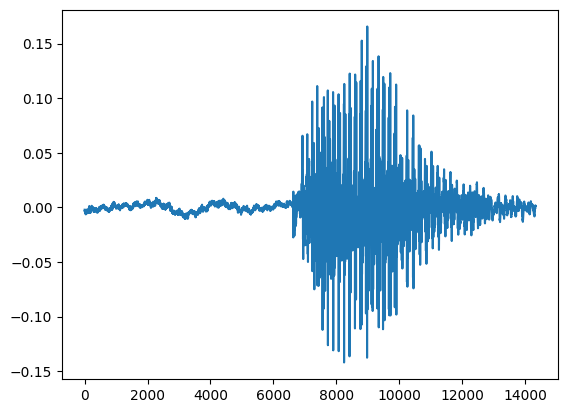

In [ ]:
import matplotlib.pyplot as plt
plt.plot(wav)

In [ ]:
x=np.array(x)
y=np.array(y)

In [ ]:
x.shape

(8000, 128, 110)

In [ ]:
y = tf.keras.utils.to_categorical(y)

x.shape

(8000, 128, 110)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1,shuffle=True,stratify=y)

In [ ]:
x_train.shape

(7200, 128, 110)

In [ ]:
y_train.shape

(7200, 8)

In [ ]:
model = models.Sequential()

model.add(layers.InputLayer(x_train[0].shape))
model.add(layers.Reshape([x_train.shape[1],x_train.shape[2],-1]))
model.add(layers.Resizing(32,32))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(32,4,activation='relu',padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64,4,activation='relu',padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(y_train.shape[1],activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 128, 110, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,108 (1.13 MB)

 Trainable params: 296,106 (1.13 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_split=0.1,
                    batch_size=32)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2376 - loss: 1.9874 - val_accuracy: 0.4903 - val_loss: 1.4760
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4706 - loss: 1.4797 - val_accuracy: 0.6917 - val_loss: 1.0025
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5931 - loss: 1.1165 - val_accuracy: 0.7375 - val_loss: 0.8176
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6710 - loss: 0.9104 - val_accuracy: 0.7986 - val_loss: 0.6905
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.7862 - val_accuracy: 0.8111 - val_loss: 0.6492
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7352 - loss: 0.7119 - val_accuracy: 0.8278 - val_loss: 0.5764
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7785 - loss: 0.6507 - val_accuracy: 0.8306 - val_loss: 0.5681
Epoch 8/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7805 - loss: 0.6102 - val_accuracy: 

Text(0, 0.5, 'Accuracy [%]')

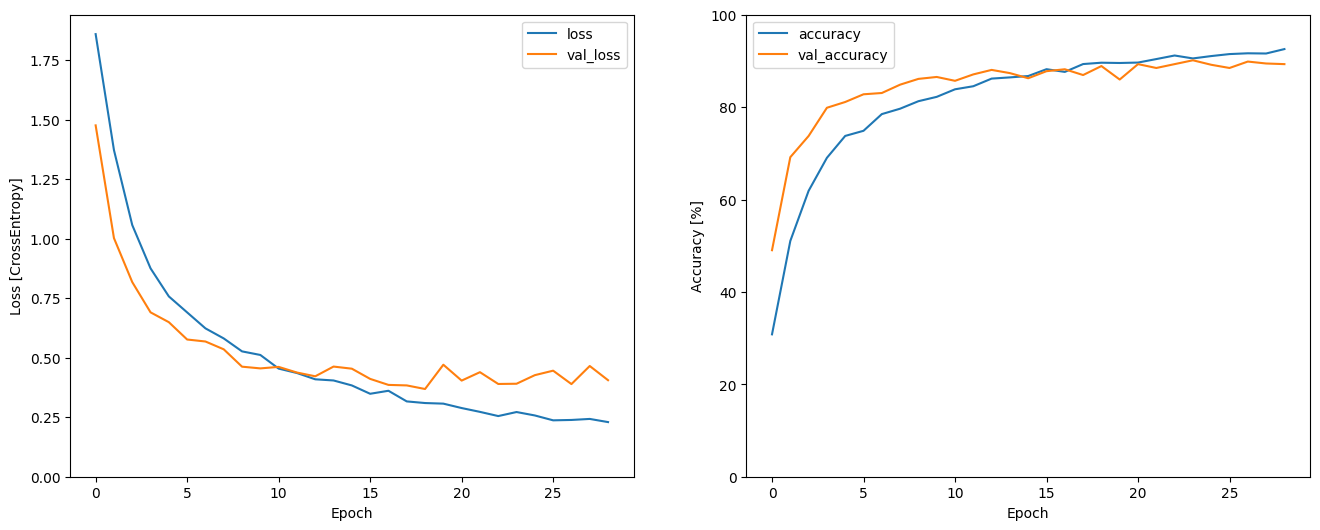

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(x_test,y_test, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9016 - loss: 0.4133 


{'accuracy': 0.8962500095367432, 'loss': 0.4089401364326477}

In [ ]:
model.save('model.h5')

In [ ]:
def representative_dataset_gen():
    for i in range(50):
      input = x_train[i:i+1].astype(np.float32)
      yield [input]

# model directory.
MODEL_DIR = "model"
model.export(MODEL_DIR)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()
with open("model.tflite","wb") as f:
    f.write(tflite_model)

Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 110), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  134661070446736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134661070443040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134661070444096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134661070444624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657493915200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657493917488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657493921888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657493924176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657494131008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657494133824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134657494135408: TensorSp